In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
import time
import gc
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn import neighbors
from sklearn import ensemble
from sklearn import tree

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Overview of the total shopping time of passnegers

In [0]:
root,dirs,files = list(os.walk("/content/drive/My Drive/inf560/tstdata"))[0]
infiles = [os.path.join(root,f) for f in files]
# infiles[8:16]
dfs=[]
for f in infiles[:16]:
    df = pd.read_csv(f,names=['macid','total_shopping_time'])
    dfs.append(df)
dfa1 = pd.concat(dfs[:7])
dfa2 = pd.concat(dfs[8:])
print("old:",dfa1.shape,", new:",dfa2.shape)


old: (76155, 2) , new: (896327, 2)


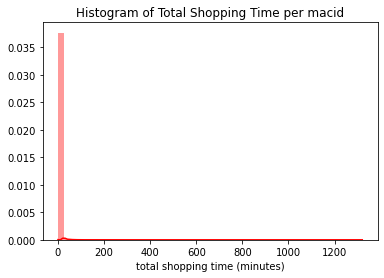

In [0]:
# Overview of total shopping time distribution
ax = sns.distplot(dfa2.total_shopping_time.apply(lambda x:x/60), color='r')
ax.set(xlabel="total shopping time (minutes)",ylabel="", title='Histogram of Total Shopping Time per macid')
plt.show()

In [0]:
dfa2.describe()

,total_shopping_time
count,896327.000000
mean,56.510951
std,473.269847
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,79203.000000


In [0]:
thre = dfa2['total_shopping_time'].quantile(0.996)
dfa2_flt = dfa2[dfa2['total_shopping_time']<thre]
dfa2_flt.describe()

,total_shopping_time
count,892738.000000
mean,39.095996
std,162.221731
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1964.000000


In [0]:
dfa2_flt[dfa2_flt['total_shopping_time']>0].describe()

,total_shopping_time
count,117757.000000
mean,296.394108
std,351.062529
min,1.000000
25%,71.000000
50%,161.000000
75%,372.000000
max,1964.000000


In [0]:
# filter out some passengers with extremely high total shopping time
dfs2=[]
for df in dfs[8:]: 
    df = df[df['total_shopping_time']<thre]
    dfs2.append(df)

# concat some df
dfs3,dfinner=[],[]
for i in range(len(dfs2)):
    if 0<i<5:
        dfinner.append(dfs2[i])
        if i==2 or i==4:
            dfs3.append(pd.concat(dfinner))
    else:
        dfs3.append(dfs2[i])
# dfs3
for i in range(len(dfs3)):
    dfs3[i].to_csv("/content/drive/My Drive/inf560/tstdata/tst_new"+str(i)+".csv")

# Load csv data into memory

In [4]:
missing_values = ["n/a", "na", "--", "None", "nan"]
# flight_shopping = pd.read_csv("flight_shopping.csv", na_values = missing_values)
file_path = "/content/drive/My Drive/inf560/passenger_flight_mapping/flight_shopping_0_percent.csv"
file_path = "/content/drive/My Drive/inf560/passenger_flight_mapping/flight_shopping_05_percent.csv"
# file_path = "/content/drive/My Drive/inf560/passenger_flight_mapping/flight_shopping_10_percent.csv"
flight_shopping_original = pd.read_csv(file_path, na_values = missing_values)
flight_shopping_original.shape

(4235, 8)

xinyang's route

In [0]:
missing_values = ["n/a", "na", "--", "None", "nan"]
# flight_shopping = pd.read_csv("flight_shopping.csv", na_values = missing_values)
file_path = "/content/drive/My Drive/inf560/shopping_time_by_flight/flight_shopping_0_percent.csv"
file_path = "/content/drive/My Drive/inf560/shopping_time_by_flight/flight_shopping_05_percent.csv"
# file_path = "/content/drive/My Drive/inf560/passenger_flight_mapping/flight_shopping_10_percent.csv"
flight_shopping_original = pd.read_csv(file_path, na_values = missing_values)
flight_shopping_original.shape

(4235, 8)

# Preprocessing

In [157]:
flight_shopping = flight_shopping_original
flight_shopping = flight_shopping[((flight_shopping['sum(estimated_time)'] - flight_shopping['sum(estimated_time)'].mean()) / flight_shopping['sum(estimated_time)'].std()).abs() < 3]
print(flight_shopping.shape)
flight_shopping.head()

(4191, 8)


,Gate,Arrival,Date,Schedule_Depart_Time,Actual_Depart_Time,Actual_Arrival_Time,Flying_Hours,sum(estimated_time)
0,C44,Bogota,10/18/2019,6.5,7.316667,11:39,6:20,1705.395432
1,C44,Bogota,10/19/2019,6.5,6.683333,10:53,6:12,6722.978906
2,C44,Bogota,10/20/2019,6.5,7.266667,11:31,6:15,16.548587
3,C44,Bogota,10/21/2019,6.5,6.916667,11:31,6:36,4451.408472
4,C44,Bogota,10/23/2019,6.5,7.850000,12:25,6:34,9134.047758


In [158]:
flight_shopping['sum(estimated_time)'].describe()

count     4191.000000
mean      7935.217889
std       5988.216231
min          4.785662
25%       3432.541409
50%       6645.502838
75%      10924.022927
max      34837.055563
Name: sum(estimated_time), dtype: float64

In [159]:
# discard some outliers
et_low = flight_shopping['sum(estimated_time)'].quantile(0.2)
et_high = flight_shopping['sum(estimated_time)'].quantile(0.75)

flight_shopping = flight_shopping[(flight_shopping['sum(estimated_time)']<et_high)&(flight_shopping['sum(estimated_time)']>et_low)]

print("et_low: ",et_low,", et_high: ",et_high)

train_x = flight_shopping[['Gate', 'Arrival', 'Date', 'Schedule_Depart_Time', 'Flying_Hours']]
print(train_x.shape)

def sec_min(x):
    # convert seconds to minutes
    return x/60

train_y = flight_shopping[['sum(estimated_time)']]
train_y = train_y.apply(sec_min)

et_low:  2815.4744703399897 , et_high:  10924.022927127251
(2304, 5)


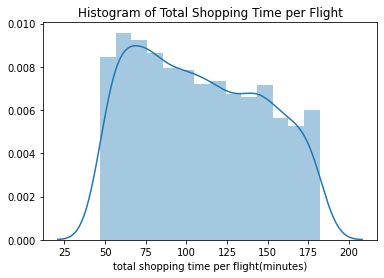

In [160]:
ax = sns.distplot(train_y)
ax.set(xlabel="total shopping time per flight(minutes)",ylabel="", title='Histogram of Total Shopping Time per Flight')
plt.show()

In [161]:
train_x.isnull().sum()

Gate                     0
Arrival                  0
Date                     0
Schedule_Depart_Time     0
Flying_Hours            57
dtype: int64

In [162]:
def hour_convert(x):
    if type(x) == str:
        h,m = map(int,x.split(':'))
        return (h*60+m)
    else:
        print(type(x))
        print(x)
        return x

def hr_min(x):
    # convert hours to minutes
    return x*60

train_x.Flying_Hours = train_x.Flying_Hours.fillna('0:0')
train_x.Flying_Hours = train_x.Flying_Hours.apply(hour_convert)

train_x.Schedule_Depart_Time = train_x.Schedule_Depart_Time.apply(hr_min)

mean_flying_time = train_x.Flying_Hours.mean()
print("mean flying minutes:",mean_flying_time)

mean flying minutes: 434.87152777777777


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [163]:
def fill_0(x):
    if x == 0:
        x = mean_flying_time
    return x

train_x.Flying_Hours = train_x.Flying_Hours.apply(fill_0)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [164]:
train = flight_shopping
train_x['Date'] = pd.to_datetime(train_x['Date'], errors='coerce')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Data Transformation

In [165]:
def time_convert(x):
    h,m = map(int,x.split(':'))
    return (h*60+m)

def aggregate_nmt(train):
    train['year'] = train['Date'].dt.year
    train['weekofyear'] = train['Date'].dt.weekofyear
    train['month'] = train['Date'].dt.month
    train['dayofweek'] = train['Date'].dt.dayofweek

    train.loc[:, 'Date'] = pd.DatetimeIndex(train['Date']).astype(np.int64) * 1e-9

    train = pd.get_dummies(train, columns=['Gate', 'Arrival'])
    # train = pd.get_dummies(train, columns=['Gate', 'Arrival','weekofyear','month','dayofweek'])

    return train


train_x = aggregate_nmt(train_x)
train_x.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Date,Schedule_Depart_Time,Flying_Hours,year,weekofyear,month,dayofweek,Gate_C44,Gate_C45,Gate_C46,Gate_C47,Gate_C48,Gate_C49,Gate_C50,Gate_C51,Gate_C52,Gate_C53,Gate_C54,Gate_C55,Gate_C56,Gate_C57,Gate_C58,Gate_C59,Gate_C60,Gate_C61,Gate_C62,Gate_C63,Gate_C64,Gate_C65,Gate_C66,Gate_C67,Gate_C69,Arrival_Amsterdam,Arrival_Atlanta,Arrival_Bogota,Arrival_Buenos Aires,Arrival_Campinas,Arrival_Casablanca,Arrival_Cordoba,Arrival_Doha,Arrival_Dubai,Arrival_Frankfurt,Arrival_Houston,Arrival_Lima,Arrival_Lisbon,Arrival_London,Arrival_Luanda,Arrival_Madrid,Arrival_Miami,Arrival_Montevideo,Arrival_New York,Arrival_Panama City,Arrival_Paris,Arrival_Porto,Arrival_Recife,Arrival_Rome,Arrival_Rosario,Arrival_Salvador,Arrival_Santiago,Arrival_Zurich
1,1.571443e+09,390.0,372.0,2019,42,10,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.571616e+09,390.0,396.0,2019,43,10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.571789e+09,390.0,394.0,2019,43,10,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.576800e+09,385.0,371.0,2019,51,12,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1.570666e+09,455.0,215.0,2019,41,10,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Train Models (Linear Regression, Elastic Net, Bayesian Ridge, KNN, Gradient Boosting, Lasso, Decision Tree, Ada Boosting)

## Linear Regression

In [0]:
def kfold_LinearRegression(train_df, y, stratified = False):
    if stratified:
        folds = StratifiedKFold(shuffle=True, random_state=17)
    else:
        # do 5*2 cross validation
        folds = RepeatedKFold(n_repeats=2, random_state=17)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]

        reg = linear_model.LinearRegression()
        reg.fit(train_x, train_y)
        
        oof_preds[valid_idx] = reg.predict(valid_x)[0]

        print('Fold %2d RMSE : %.6f' % (n_fold, np.sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))))      
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    rmse = np.sqrt(mean_squared_error(y, oof_preds))
    print('Full RMSE score %.6f' % rmse)


In [167]:
# using linear regression model
kfold_LinearRegression(train_x, train_y, stratified = False)

FOLD 0
Fold  0 RMSE : 40.964156
FOLD 1
Fold  1 RMSE : 44.052025
FOLD 2
Fold  2 RMSE : 44.896948
FOLD 3
Fold  3 RMSE : 41.135822
FOLD 4
Fold  4 RMSE : 42.035568
FOLD 5
Fold  5 RMSE : 41.979239
FOLD 6
Fold  6 RMSE : 43.466337
FOLD 7
Fold  7 RMSE : 39.227638
FOLD 8
Fold  8 RMSE : 39.671085
FOLD 9
Fold  9 RMSE : 45.883499
Full RMSE score 42.115930


## ElasticNet

In [168]:
# first find the best params for the model using GridSearchCV
def find_best_params(train_x, train_y, estimator, params):
    # do 5*2 cross validation
    folds = RepeatedKFold(n_repeats=2, random_state=17)
    
    # tuning the hyper-parameters
    reg = GridSearchCV(estimator, params, scoring='neg_mean_squared_error', cv=folds)
    reg.fit(train_x, train_y)
    print("best model:",reg.best_estimator_)
    print("best param:",reg.best_params_)
    print("best rmse score:",(reg.best_score_*-1)**0.5)

enreg = linear_model.ElasticNet()
params = {'alpha':np.linspace(0.076,0.08,12), 'l1_ratio': np.linspace(0.99,1.01,7)}

find_best_params(train_x, train_y, enreg, params)

best model: ElasticNet(alpha=0.076, copy_X=True, fit_intercept=True,
           l1_ratio=1.0033333333333334, max_iter=1000, normalize=False,
           positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)
best param: {'alpha': 0.076, 'l1_ratio': 1.0033333333333334}
best rmse score: 37.42530981472659


In [0]:
# Linear regression with combined L1 and L2 priors as regularizer.
# train the test model using l1, l2 penalty linear regression
def kfold_ElasticNet(train_df, y, stratified = False):
    if stratified:
        folds = StratifiedKFold(shuffle=True, random_state=17)
    else:
        # do 5*2 cross validation
        folds = RepeatedKFold(n_repeats=2, random_state=17)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]
        
        reg = linear_model.ElasticNet(alpha=0.076, l1_ratio=1.0033333333333334)
        reg.fit(train_x, train_y)
        
        oof_preds[valid_idx] = reg.predict(valid_x)[0]

        print('Fold %2d RMSE : %.6f' % (n_fold, np.sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))))      
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    rmse = np.sqrt(mean_squared_error(y, oof_preds))
    print('Full RMSE score %.6f' % rmse)
     

In [170]:
# using ElasticNet model
kfold_ElasticNet(train_x, train_y, stratified = False)

FOLD 0
Fold  0 RMSE : 39.927260
FOLD 1
Fold  1 RMSE : 41.768026
FOLD 2
Fold  2 RMSE : 41.519687
FOLD 3
Fold  3 RMSE : 40.060097
FOLD 4
Fold  4 RMSE : 40.847826
FOLD 5
Fold  5 RMSE : 40.939186
FOLD 6
Fold  6 RMSE : 40.715271
FOLD 7
Fold  7 RMSE : 39.047559
FOLD 8
Fold  8 RMSE : 39.107938
FOLD 9
Fold  9 RMSE : 42.999117
Full RMSE score 40.586647


## Bayesian Ridge

In [0]:
# find the best param for model
reg = linear_model.BayesianRidge()
params = {'alpha_1':[1,3,5,7], 'alpha_2': [4e-8,4.5e-8,3.5e-8], 'lambda_1':[6e-8,5e-8,7e-8], 'lambda_2':[8e-6,7e-6,9e-6]}

find_best_params(train_x, train_y, reg, params)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

best model: BayesianRidge(alpha_1=7, alpha_2=4e-08, alpha_init=None, compute_score=False,
              copy_X=True, fit_intercept=True, lambda_1=5e-08, lambda_2=9e-06,
              lambda_init=None, n_iter=300, normalize=False, tol=0.001,
              verbose=False)
best param: {'alpha_1': 7, 'alpha_2': 4e-08, 'lambda_1': 5e-08, 'lambda_2': 9e-06}
best rmse score: 38.104956276588375


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [0]:
def kfold_BayesianRidge(train_df, y, stratified = False):
    if stratified:
        folds = StratifiedKFold(shuffle=True, random_state=17)
    else:
        # do 5*2 cross validation
        folds = RepeatedKFold(n_repeats=2, random_state=17)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]
        
        reg = linear_model.BayesianRidge(alpha_1=7, alpha_2=4e-08, lambda_1=5e-08, lambda_2=9e-06)
        reg.fit(train_x, train_y)
        
        oof_preds[valid_idx] = reg.predict(valid_x)[0]

        print('Fold %2d RMSE : %.6f' % (n_fold, np.sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))))      
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    rmse = np.sqrt(mean_squared_error(y, oof_preds))
    print('Full RMSE score %.6f' % rmse)


In [172]:
# using BayesianRidge model
kfold_BayesianRidge(train_x, train_y, stratified = False)

FOLD 0
Fold  0 RMSE : 38.621277
FOLD 1
Fold  1 RMSE : 38.911306


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 2
Fold  2 RMSE : 42.534738
FOLD 3
Fold  3 RMSE : 39.348520


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 4
Fold  4 RMSE : 38.188898
FOLD 5
Fold  5 RMSE : 38.170464
FOLD 6


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold  6 RMSE : 38.556487
FOLD 7
Fold  7 RMSE : 39.028276
FOLD 8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold  8 RMSE : 39.160496
FOLD 9
Fold  9 RMSE : 39.683382
Full RMSE score 38.922947


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## KNN

In [54]:
# find the best param for model
knn = neighbors.KNeighborsRegressor()
params = {'n_neighbors':np.linspace(20,600,6,dtype=int), 'leaf_size': np.linspace(4,15,6,dtype=int), 'weights':['uniform','distance'], 'p':[1]}

find_best_params(train_x, train_y, knn, params)

best model: KNeighborsRegressor(algorithm='auto', leaf_size=8, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=600, p=1,
                    weights='distance')
best param: {'leaf_size': 8, 'n_neighbors': 600, 'p': 1, 'weights': 'distance'}
best rmse score: 38.244067348899584


In [0]:
# K Nearest Neighbor
# train the test model using KNN
def kfold_KNN(train_df, y, stratified = False):
    if stratified:
        folds = StratifiedKFold(shuffle=True, random_state=17)
    else:
        # do 5*2 cross validation
        folds = RepeatedKFold(n_repeats=2, random_state=17)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]
        
        knn = neighbors.KNeighborsRegressor(leaf_size=8, n_neighbors=600, p=1, weights='distance')
        knn.fit(train_x, train_y)
        
        oof_preds[valid_idx] = knn.predict(valid_x)[0]

        print('Fold %2d RMSE : %.6f' % (n_fold, np.sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))))      
        del knn, train_x, train_y, valid_x, valid_y
        gc.collect()

    rmse = np.sqrt(mean_squared_error(y, oof_preds))
    print('Full RMSE score %.6f' % rmse)


In [174]:
# using KNN model
sub_preds_knn = kfold_KNN(train_x, train_y, stratified = False)

FOLD 0
Fold  0 RMSE : 38.728044
FOLD 1
Fold  1 RMSE : 38.890786
FOLD 2
Fold  2 RMSE : 43.962922
FOLD 3
Fold  3 RMSE : 47.603424
FOLD 4
Fold  4 RMSE : 38.223003
FOLD 5
Fold  5 RMSE : 38.466791
FOLD 6
Fold  6 RMSE : 40.218653
FOLD 7
Fold  7 RMSE : 50.981641
FOLD 8
Fold  8 RMSE : 45.278209
FOLD 9
Fold  9 RMSE : 43.514186
Full RMSE score 43.909082


## Gradient Boosting

In [37]:
# find the best param for model
gradientBoosting = ensemble.GradientBoostingRegressor(random_state=21)
params = {'learning_rate':[0.10081,0.10084,0.10087],
          'n_estimators':[27,25],
          'alpha':[0.68,0.5],
          'min_samples_split':[5,7]}

find_best_params(train_x, train_y['sum(estimated_time)'], gradientBoosting, params)

best model: GradientBoostingRegressor(alpha=0.68, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.10087, loss='ls',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=7,
                          min_weight_fraction_leaf=0.0, n_estimators=27,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
best param: {'alpha': 0.68, 'learning_rate': 0.10087, 'min_samples_split': 7, 'n_estimators': 27}
best rmse score: 36.28686098190549


In [0]:
# train the test model using gradientBoosting
def kfold_GradientBoosting(train_df, y, stratified = False):
    if stratified:
        folds = StratifiedKFold(shuffle=True, random_state=17)
    else:
        # do 5*2 cross validation
        folds = RepeatedKFold(n_repeats=2, random_state=17)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]
        
        gradientBoosting = ensemble.GradientBoostingRegressor(alpha=0.68, learning_rate=0.10087, n_estimators=25, random_state=21, min_samples_split=7)
        gradientBoosting.fit(train_x, train_y)
        
        oof_preds[valid_idx] = gradientBoosting.predict(valid_x)[0]

        print('Fold %2d RMSE : %.6f' % (n_fold, np.sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))))      
        del gradientBoosting, train_x, train_y, valid_x, valid_y
        gc.collect()

    rmse = np.sqrt(mean_squared_error(y, oof_preds))
    print('Full RMSE score %.6f' % rmse)



In [176]:
# using GradientBoosting model
kfold_GradientBoosting(train_x, train_y, stratified = False)

FOLD 0
Fold  0 RMSE : 38.618309
FOLD 1


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold  1 RMSE : 39.427009
FOLD 2
Fold  2 RMSE : 39.018434
FOLD 3


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold  3 RMSE : 38.843949
FOLD 4
Fold  4 RMSE : 37.955722
FOLD 5


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold  5 RMSE : 37.976894
FOLD 6
Fold  6 RMSE : 38.501334
FOLD 7


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold  7 RMSE : 38.855747
FOLD 8
Fold  8 RMSE : 38.524103
FOLD 9


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold  9 RMSE : 39.888049
Full RMSE score 38.753931


## Lasso

In [0]:
# find the best param for model
las = linear_model.Lasso()
params = {'alpha':np.logspace(-7,3,50)}

find_best_params(train_x, train_y, las, params)
# best model: Lasso(alpha=0.012648552168552958, copy_X=True, fit_intercept=True,
#       max_iter=1000, normalize=False, positive=False, precompute=False,
#       random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
# best param: {'alpha': 0.012648552168552958}
# best rmse score: 37.363905134121175


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1191474.1283954447, tolerance: 272.24666375545775
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1146316.9366382044, tolerance: 273.67002480974173
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1171390.513388235, tolerance: 271.5618870705148
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1175601.

best model: Lasso(alpha=0.012648552168552958, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
best param: {'alpha': 0.012648552168552958}
best rmse score: 37.363905134121175


In [0]:
# Lasso
# train the test model using Lasso
def Lasso (train_df, y, stratified = False):
    if stratified:
        folds = StratifiedKFold(shuffle=True, random_state=17)
    else:
        # do 5*2 cross validation
        folds = RepeatedKFold(n_repeats=2, random_state=17)

    oof_preds = np.zeros(train_df.shape[0])

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]

        las = linear_model.Lasso(alpha=0.012648552168552958)
        las.fit(train_x, train_y)
        
        oof_preds[valid_idx] = las.predict(valid_x)[0]

        print('Fold %2d RMSE : %.6f' % (n_fold, np.sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))))      
        del las, train_x, train_y, valid_x, valid_y
        gc.collect()

    rmse = np.sqrt(mean_squared_error(y, oof_preds))
    print('Full RMSE score %.6f' % rmse)

In [178]:
# using Lasso model
Lasso(train_x, train_y, stratified = False)
# Full RMSE score 42.013980

FOLD 0
Fold  0 RMSE : 41.039681
FOLD 1
Fold  1 RMSE : 43.983324
FOLD 2
Fold  2 RMSE : 44.434806
FOLD 3
Fold  3 RMSE : 40.769565
FOLD 4
Fold  4 RMSE : 41.774075
FOLD 5
Fold  5 RMSE : 42.392692
FOLD 6
Fold  6 RMSE : 43.061508
FOLD 7
Fold  7 RMSE : 39.198021
FOLD 8
Fold  8 RMSE : 39.444655
FOLD 9
Fold  9 RMSE : 45.637286
Full RMSE score 42.013980


## Decision Tree

In [0]:
# find the best param for model
dec = tree.DecisionTreeRegressor()
params = {'max_depth':np.linspace(3,5,3,dtype=int),
          'min_samples_split':np.linspace(2,3,3,dtype=int),
          'min_samples_leaf':np.linspace(8,15,8,dtype=int)}
          # 'min_weight_fraction_leaf':np.linspace(0,0.3,5,dtype=float),
          # 'max_features':np.linspace(8,12,10,dtype=int)}

find_best_params(train_x, train_y, dec, params)

# best param: {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 2}
# best rmse score: 36.710298238842505

best model: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
best param: {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 2}
best rmse score: 36.710298238842505


In [0]:
# Decision Tree
# train the test model using desicion tree
def Decisiontreeregr (train_df, y, stratified = False):
    if stratified:
        folds = StratifiedKFold(shuffle=True, random_state=17)
    else:
        # do 5*2 cross validation
        folds = RepeatedKFold(n_repeats=2, random_state=17)

    oof_preds = np.zeros(train_df.shape[0])

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]

        dec = tree.DecisionTreeRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=10)
        dec.fit(train_x, train_y)
        
        oof_preds[valid_idx] = dec.predict(valid_x)[0]

        print('Fold %2d RMSE : %.6f' % (n_fold, np.sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))))      
        del dec, train_x, train_y, valid_x, valid_y
        gc.collect()

    rmse = np.sqrt(mean_squared_error(y, oof_preds))
    print('Full RMSE score %.6f' % rmse)

In [180]:
# using decision tree model

sub_preds_dec = Decisiontreeregr(train_x, train_y, stratified = False)

# Full RMSE score 38.692904

FOLD 0
Fold  0 RMSE : 39.196946
FOLD 1
Fold  1 RMSE : 38.217182
FOLD 2
Fold  2 RMSE : 39.524483
FOLD 3
Fold  3 RMSE : 38.772169
FOLD 4
Fold  4 RMSE : 37.676755
FOLD 5
Fold  5 RMSE : 37.757100
FOLD 6
Fold  6 RMSE : 38.564003
FOLD 7
Fold  7 RMSE : 38.798619
FOLD 8
Fold  8 RMSE : 39.121709
FOLD 9
Fold  9 RMSE : 39.206749
Full RMSE score 38.692904


## AdaBoostRegressor

In [199]:
# find the best param for model
ada = ensemble.AdaBoostRegressor()
params = {'n_estimators':np.linspace(24,32,4,dtype=int),
          'loss':['linear', 'square'],
          'learning_rate':np.linspace(0,1,10,dtype=float)}
          # 'min_weight_fraction_leaf':np.linspace(0,0.3,5,dtype=float),
          # 'max_features':np.linspace(8,12,10,dtype=int)}

find_best_params(train_x, train_y, ada, params)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: learning_rate must be greater than zero

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

best model: AdaBoostRegressor(base_estimator=None, learning_rate=0.1111111111111111,
                  loss='linear', n_estimators=29, random_state=None)
best param: {'learning_rate': 0.1111111111111111, 'loss': 'linear', 'n_estimators': 29}
best rmse score: 36.99562593152915


In [0]:
# Ada Boosting
# train the test model using AdaBoosting
def AdaBoostregr (train_df, y, stratified = False):
    if stratified:
        folds = StratifiedKFold(shuffle=True, random_state=17)
    else:
        # do 5*2 cross validation
        folds = RepeatedKFold(n_repeats=2, random_state=17)

    oof_preds = np.zeros(train_df.shape[0])

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]
        
        ada = ensemble.AdaBoostRegressor(learning_rate= 0.111111111111111, loss='linear', n_estimators=29,
                                         base_estimator=tree.DecisionTreeRegressor(max_depth=4), random_state=7)
        ada.fit(train_x, train_y)
        
        oof_preds[valid_idx] = ada.predict(valid_x)[0]

        print('Fold %2d RMSE : %.6f' % (n_fold, np.sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))))      
        del ada, train_x, train_y, valid_x, valid_y
        gc.collect()

    rmse = np.sqrt(mean_squared_error(y, oof_preds))
    print('Full RMSE score %.6f' % rmse)

In [198]:
# using decision tree model
sub_preds_dec = AdaBoostregr(train_x, train_y, stratified = False)

FOLD 0
Fold  0 RMSE : 38.753932


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 1
Fold  1 RMSE : 38.849158


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 2
Fold  2 RMSE : 39.063040


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 3
Fold  3 RMSE : 39.236510


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 4
Fold  4 RMSE : 37.679522


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 5
Fold  5 RMSE : 37.757059


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 6
Fold  6 RMSE : 38.236997


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 7
Fold  7 RMSE : 38.828115


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 8
Fold  8 RMSE : 38.501759


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


FOLD 9
Fold  9 RMSE : 39.211313


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Full RMSE score 38.509947


#Overall Results


In [0]:
from prettytable import PrettyTable

In [128]:
table = PrettyTable()
table.add_column('Model', ['XGBoost','LightGBM','AdaBoosting',
                           'Decision Tree','Gradient Boosting','Bayesian Ridge',
                           'ElasticNet','Lasso','Linear Regression', 'KNN'])
table.add_column('RMSE', ['33.978181','35.199379',
                           '38.509947','38.692904','38.753931','38.922947',
                           '40.586647','42.013980','42.115930','43.909082'])
print(table)

+-------------------+-----------+
|       Model       |    RMSE   |
+-------------------+-----------+
|      XGBoost      | 33.978181 |
|      LightGBM     | 35.199379 |
|    AdaBoosting    | 38.509947 |
|   Decision Tree   | 38.692904 |
| Gradient Boosting | 38.753931 |
|   Bayesian Ridge  | 38.922947 |
|     ElasticNet    | 40.586647 |
|       Lasso       | 42.013980 |
| Linear Regression | 42.115930 |
|        KNN        | 43.909082 |
+-------------------+-----------+
